In [6]:
print("Aici incepe codul.")
import os
from PIL import Image, ImageDraw as D
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

Aici incepe codul.


In [7]:
PATH_DATA = "new_fronts/"
types = ["cold", "occluded", "warm", "white"]
size = (32, 32)

In [3]:
X = []
y = []
for type_of_front in types:
  for root, _, files in os.walk(PATH_DATA + '/' + type_of_front):
    for image_path in files:
      X.append(np.resize(np.asarray(Image.open(os.path.join(root, image_path)).resize(size)), (*size, 3)))
      y.append(np.array(types.index(type_of_front)))


X = np.asarray(X)
y = np.asarray(y)

In [4]:
print(types[0], list(y).count(0))
print(types[1], list(y).count(1))
# print(types[2], list(y).count(2))
# print(types[3], list(y).count(3))

cold 131
warm 162


In [8]:
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(*size, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(256, activation='relu'),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(64, activation='relu'),
#   layers.Dense(len(types))
# ])
from tensorflow.keras.applications import vgg16
# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(*size, 3))

In [9]:
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8a6cb44190> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c1b5f40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c1b5eb0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f8a6c146580> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c145d30> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c145c10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f8a6c14c1f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c14f790> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c14ff10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c14fdf0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f8a6c189d90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8a6c1d3280> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f8b28058100> False
<keras.layers.convolut

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_dir = 'dataset_final_1/train'
test_dir = 'dataset_final_1/test'
# Data generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=size,
    batch_size = 11,
    class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=size,
    batch_size = 11,
    class_mode='categorical',
    shuffle=False)

print(train_generator.num_classes)

Found 805 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
4


In [17]:
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [18]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy']
#               )
from keras import optimizers
model.compile(  loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [20]:
epochs = 32
history = model.fit(
    x=train_generator,
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/32
74/74 [==============================] - 3s 31ms/step - loss: 1.2559 - accuracy: 0.4273 - val_loss: 1.0362 - val_accuracy: 0.5250
Epoch 2/32
74/74 [==============================] - 2s 29ms/step - loss: 1.0397 - accuracy: 0.5304 - val_loss: 0.8696 - val_accuracy: 0.5813
Epoch 3/32
74/74 [==============================] - 2s 30ms/step - loss: 0.9494 - accuracy: 0.5553 - val_loss: 0.8289 - val_accuracy: 0.6250
Epoch 4/32
74/74 [==============================] - 2s 29ms/step - loss: 0.8642 - accuracy: 0.6149 - val_loss: 0.8609 - val_accuracy: 0.5938
Epoch 5/32
74/74 [==============================] - 2s 29ms/step - loss: 0.8220 - accuracy: 0.6323 - val_loss: 0.8004 - val_accuracy: 0.6125
Epoch 6/32
74/74 [==============================] - 2s 29ms/step - loss: 0.8055 - accuracy: 0.6522 - val_loss: 0.7732 - val_accuracy: 0.6375
Epoch 7/32
74/74 [==============================] - 2s 29ms/step - loss: 0.7659 - accuracy: 0.6783 - val_loss: 0.8010 - val_accuracy: 0.6062
Epoch 8/32
74

(500, 800, 3)


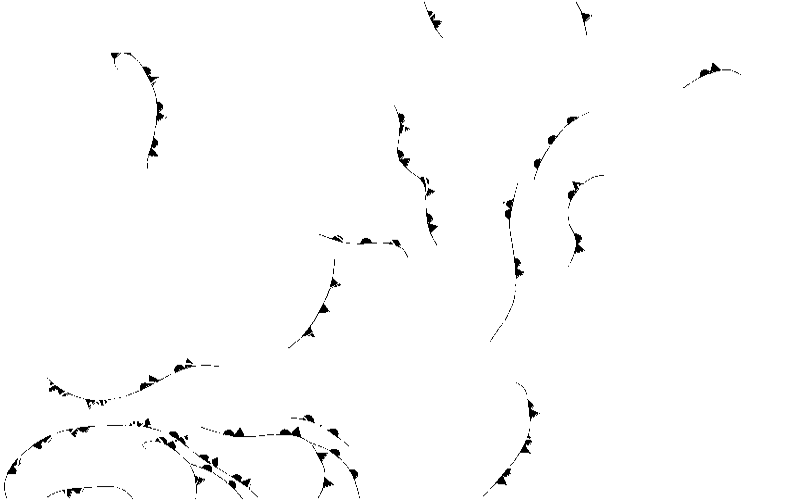

In [37]:
TO_PREDICT_PATH = "/media/luca/1A46739246736D7F/Users/Luca/Semestrul 5/MIRPR/project-frontfinders/model_utils/fronts/to_predict/" 
for root, _, files in os.walk(TO_PREDICT_PATH):
    for image_path in files:
      img = np.asarray(Image.open(os.path.join(root, image_path)).resize((800, 500)))
      img = img.reshape((500, 800, 3))

print(img.shape)
display(Image.fromarray(img))


In [38]:
model = keras.models.load_model("models/model_v1.h5")

In [39]:
x_size, y_size = size
crops = [((x, y), (x + x_size, y + y_size), img[x:x+x_size, y:y+y_size] / 255) for x in range(0, img.shape[0], x_size) for y in range(0,img.shape[1], y_size)]
predictions = model.predict(np.array([crop[-1] for crop in crops if crop[-1].shape == (*size, 3)]))
future_rectangles = [(start, end, prediciton, prediciton.argmax()) for (start, end, _), prediciton in zip(crops, predictions)]

12/12 [==============================] - 1s 51ms/step


In [40]:
train_generator.class_indices


{'cold': 0, 'occluded': 1, 'warm': 2, 'white': 3}

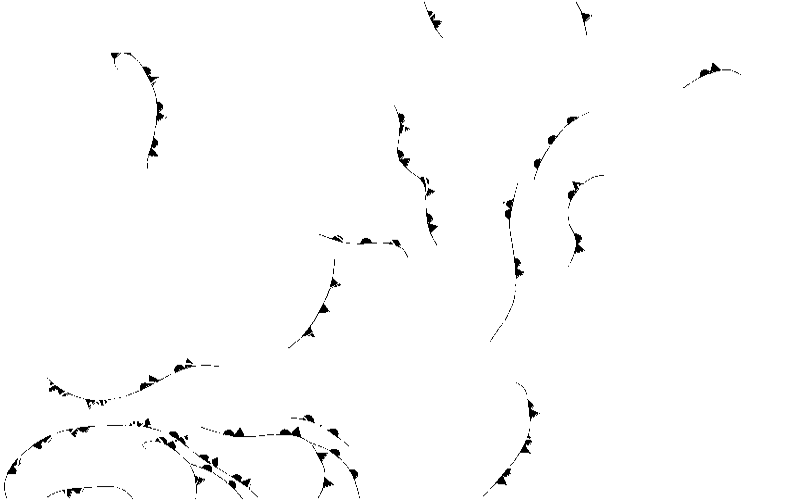

['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0285701007', '0.2118998319', '0.7548307180', '0.0046993825']
['0.0000092860', '0.0000023649', '0.0000117390', '0.9999765754']
['0.0000092860', '0.00000

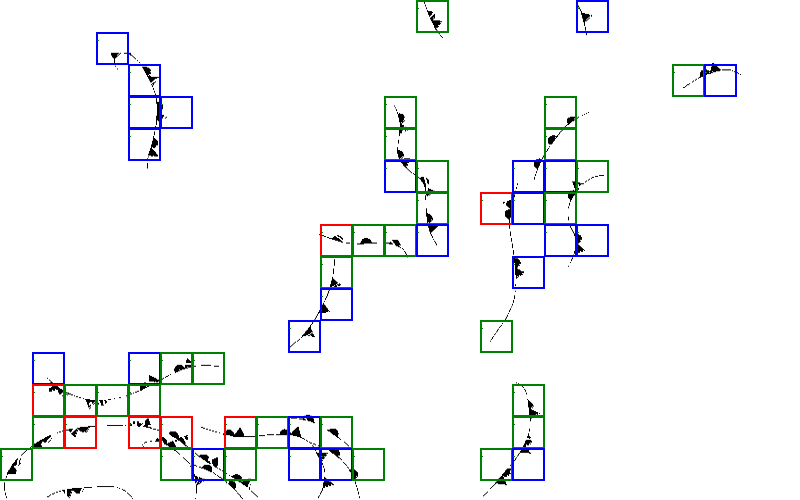

In [41]:
TO_PREDICT_PATH = "/media/luca/1A46739246736D7F/Users/Luca/Semestrul 5/MIRPR/project-frontfinders/model_utils/fronts/to_predict/" 
for root, _, files in os.walk(TO_PREDICT_PATH):
    for image_path in files:
      output_image = np.asarray(Image.open(os.path.join(root, image_path)).resize((800, 500)))
      output_image = output_image.reshape((500, 800, 3))


output_image = Image.fromarray(output_image)
display(output_image)

draw = D.Draw(output_image)
rect = {"warm": [],
        "cold": [],
        "white": []}
o = {"warm": "red",
     "cold": "blue",
     "white": "purple",
     "occluded": "green"
     }
for (x, y), (x1, y1), pred, tp in future_rectangles:
  print(list(map(lambda x: '{0:.10f}'.format(x), pred)))
  # print(pred[1] - pred[0])
  if tp != 3:
    draw.rectangle([(y, x), (y1, x1)], outline=o[types[tp]], width=2)
    draw.text((y, x), '.', fill="green", align="center")
  # draw.text((x + 10, y + 10), str(pred[1]), fill="green", align="center")
display(output_image)

# for key in rect.keys():
#   l = []
#   for (x, y) in rect[key]:
#     for (z, w) in rect[key]:
#       if z <= x + 50:
#         l.append([(x, y), (z + 50 - x, y + 50)])

In [36]:
model.save('models/model_v1.h5')

In [ ]:
model.load